# Исследование объявлений о продаже квартир

#### Цель:   
Установить параметры для определения рыночной стоимости объектов недвижимости, которые будут в дальнейшем использоваться в автоматизированной системе (которая отслеживает аномалии и мошенническую деятельность)

#### Исходные данные:  
Архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.

Вопросы, на которые необходимо дать ответы и план действий:
1. Какие факторы больше всего влияют на стоимость квартиры?  
Необходимо изучить:
   * зависит ли цена от площади, числа комнат, удалённости от центра
   * зависит ли цена от того, на каком этаже расположена квартира: первом, последнем или другом. 
   * зависит ли цена от даты размещения: дня недели, месяца и года.  
2. В 10 населённых пунктах с наибольшим числом объявлений необходимо:
   * посчитать среднюю цену квадратного метра в этих населённых пунктах
   * выделить среди них населённые пункты с самой высокой и низкой стоимостью жилья.  
3. Необходимо выделить квартиры в Санкт-Петербурге и выяснить, какая область входит в центр  
Для этого необходимо изучить предложения квартир: для каждой квартиры есть информация о расстоянии до центра.  
4. Необходимо выделить факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления) в центре Санкт-Петербурга и во всем городе  
Для этого необходимо выделить сегмент квартир в центре, проанализировать эту территорию и изучить следующие параметры: площадь, цена, число комнат, высота потолков

## Оглавление

1. [Открытие данных](#1)  
2. [Предобработка данных](#2)  
    2.1 [Обработка пропущенных значений](#2.1)  
    2.2 [Замена типа данных](#2.2)
3. [Подсчет данных](#3)  
    3.1 [Подсчет цены за 1 квадратный метр](#3.1)  
    3.2 [Определение дня недели, месяца и года публикации объявления](#3.2)  
    3.3 [Категорирование квартиры по этажности](#3.3)  
    3.4 [Определение соотношения жилой и общей площади, а также отношения площади кухни к общей](#3.4)  
4. [Анализ данных](#4)  
    4.1 [Изучение следующих параметров: площадь, цена, число комнат, высота потолков](#4.1)    
    4.2 [Изучение времени продажи квартиры](#4.2)  
    4.3 [Обработка редких и выбивающихся значений](#4.3)  
    4.4 [Изучение факторов, влияющих на стоимость квартиры](#4.4)  
    4.5 [Исследование 10 населённых пунктов с наибольшим числом объявлений](#4.5)  
    4.6 [Определение центральной зоны](#4.6)  
    4.7 [Анализ квартир в Санкт-Петербурге](#4.7)  
5. [Общий вывод](#5)

## 1. Открытие данных <a id="1"></a>

Импортируем необходимые библиотеки и функции, которые понадобятся для достижения цели. По ходу работы могут быть подключены дополнительные библиотеки, в зависимостей от задачи

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    data = pd.read_csv("real_estate_data.csv", sep='\t')
except:
    data = pd.read_csv("/datasets/real_estate_data.csv", sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


## 2. Предобработка данных<a id="2"></a>

### 2.1. Обработка пропущенных значений<a id="2.1"></a>

#### 2.1.1 Обработка пропущенных значений в `ceiling_height`

In [4]:
print('Количество пропусков =', data['ceiling_height'].isna().sum())

Количество пропусков = 9195


Почти половина из всех значений пропущена, это может быть связано с неполным заполнением данных самим продавцом. Продавец сам может не знать точную высоту потолков или он целенаправлено опустил данные, посчитав данный параметр не показательным. 
В любом случае данные являются колличественными и можем заполнить пропущенные значения медианным, сгруппировав по параметру `floor`.  
Есть строительные стандарты, которые определяют высоту потолков в жилых помещениях. Они, правда, менялись со временем (хрущевки, кажется, ниже современного жилья), но т.к. у нас нет данных о годе строительства здания, то можно заполнить общей медианой.

In [5]:
#цикл для определения медианного значения высоты потолка при группировке по этажам
for floor in data['floor'].unique():
    median = data.loc[data['floor'] == floor, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['floor'] == floor), 'ceiling_height'] = median
print('Количество пропусков =', data['ceiling_height'].isna().sum())

Количество пропусков = 4


У 4-х этажей невозможно вычислить медианные значения, потому как квартир на 28-32 этажах не так много, данных просто нет. Возьмем медианные значения ближайших этажей: для 28 этажа = 2.7, для 31-33 этажей = 2.6

In [6]:
data.loc[(data['ceiling_height'].isna()) & (data['floor'] == 28), 'ceiling_height'] = 2.7
data.loc[(data['ceiling_height'].isna()) & ((data['floor'] == 31) | (data['floor'] == 32) | (data['floor'] == 33)), 'ceiling_height'] = 2.6

In [7]:
print('Количество пропусков =', data['ceiling_height'].isna().sum())

Количество пропусков = 0


В случаях, когда при группировке по какому-либо параметру, невозможно определить медианное значение из-за отсутствия данных, определяют *глобальную медиану*. В текущем кейсе присваивание 4-м этажам (28 и 31-33) высоту потолков равной глобальной медиане будет некорректно, потому как глобальная медиана равна 4.0  
В данной ситуации обработанных данных вручную не так много (4 значения), в иной ситуации, когда таких значения будет намного больше, необходимо будет рассмотреть группировку по иному признаку. 

In [8]:
data['floor'].median()

4.0

#### 2.1.2 Обработка пропущенных значений в `floors_total`

Пропущенных всего 86 значений, поэтому в рамках обработки данных удалим строки с пропущенными значениями методом dropna()

In [9]:
print('Количество пропусков =', data['floors_total'].isna().sum())

Количество пропусков = 86


In [10]:
data.dropna(subset=['floors_total'], inplace=True)

In [11]:
print('Количество пропусков =', data['floors_total'].isna().sum())

Количество пропусков = 0


Учитывая, что пропущенных значений было малое количество, причиной возникновения пропущенных значений скорее всего является - человеческий фактор. При заполнении данных вероятнее всего не была замечена графа, или продавец не посчитал нужным заполнять информацию.

#### 2.1.3. Обработка пропущенных значений в `is_apartment`

In [12]:
print('Количество пропусков =', data['is_apartment'].isna().sum())

Количество пропусков = 20838


In [13]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Логично предположить, что пропуски - это False т.к. большинство квартир аппартаментами не являются. Заполним пропуски в `is_apartment` значением False

In [14]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

In [15]:
print('Количество пропусков =', data['is_apartment'].isna().sum())

Количество пропусков = 0


Аппартаментов намного меньше чем квартир в жилых домах. Есть вероятность, что те продавцы, кто не заполнил данный параметр при подачи объявления, просто напросто не знают что такое аппартаменты. Если честно, я и сама не знала что это до данного проекта. Этот тип квартир не сильно распространен, особенно в поселках/деревнях. 

#### 2.1.4. Обработка пропущенных значений в `balcony`

In [16]:
print('Количество пропусков =', data['balcony'].isna().sum())

Количество пропусков = 11480


Посмотрим на уникальные значения

In [17]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Ниже действие сделано в целях проверки гипотезы появления пропущенных значений, вычислим сколько пропущенных значений в г. СПб и не в СПб

In [18]:
print(len(data.loc[(data['balcony'].isna()) & (data['locality_name'] == 'Санкт-Петербург')]))

7683


In [19]:
print(len(data.loc[(data['balcony'].isna()) & (~(data['locality_name'] == 'Санкт-Петербург'))]))

3797


Логичнее всего NaN означает отсутствие балкона, т.е. значение равное 0. Заменим NaN на 0

In [20]:
data.loc[data['balcony'].isna(), 'balcony'] = 0

In [21]:
print('Количество пропусков =', data['balcony'].isna().sum())

Количество пропусков = 0


Пропущенных значений больше половины и у 7683 из них отсутсвует информация по городу Санкт-Петербург. Достаточно большие числа, чтобы просто быть ошибкой человеческого фактора. Если перейти на сайт "Яндекс.Недвижимость", откуда сделали выгрузку, то в фильтре "Балконы" можно увидеть также значение "Лоджия".
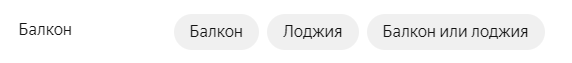  
Я бы посоветовала пообщаться с эксплуатацией и узнать, как идет заполнение и отображение таких данных. Возможно люди заполняют параметр "Лоджия", но в базе он отображается как NaN.  
Подитожим, гипотез возникновения пропущенных значений 2:  
1. Продавцы не заполнили данный параметр
2. Некорректная обработка заполнения значением "Лоджия"

#### 2.1.5. Обработка пропущенных значений в `locality_name`

Посмотрим на уникальные значения наименований

In [22]:
print('Количество пропусков =', data['locality_name'].isna().sum())

Количество пропусков = 48


In [23]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Первое, что бросается в глаза, это разное написание *поселок* и *посёлок*. Приведем к общему виду *поселок*

In [24]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')

Посмотри количество пропущенных значений

In [25]:
len(data[data['locality_name'].isna()])

48

Пропущенных значений меньше 1% от всего количества значений. Наиболее оптимальным решением будет удалить строки с пропущенными значениями, потому как на обработку потратится больше ресурсов, чем того требует задача. Воспользуемся уже знакомым методом dropna()

In [26]:
data.dropna(subset=['locality_name'], inplace=True)

In [27]:
print('Количество пропусков =', data['locality_name'].isna().sum())

Количество пропусков = 0


Причиной возникновения пропущенных значений может быть отсутствия наименования населенного пункта в списке Яндекс.Недвижимость (например, деревня с численностью 100 человек, которая на карте не отображается.

#### 2.1.6. Обработка пропущенных значений в `cityCenters_nearest`

In [28]:
print('Количество пропусков =', data['cityCenters_nearest'].isna().sum())

Количество пропусков = 5501


Заполним пропущенные значения медианой по населенному пункту, а там, где нет данных по населенному пункту, заполним глобальной медианой

Создадим переменные для хранения медианы по населенному пункту и глобальной медианы

In [29]:
cityCenters_group_median = data.groupby('locality_name').agg({'cityCenters_nearest':'median'}).reset_index()
cityCenters_global_median = data['cityCenters_nearest'].median()

Создадим функцию, заполняющую пропущенные значения медианными

In [30]:
def empty_fill_cityCenter(row):
#проверим строку на наличие пропущенного значения
    if np.isnan(row['cityCenters_nearest']):
#создаем переменную, храняющую значение нужной медианы
        current_median = cityCenters_group_median[cityCenters_group_median['locality_name'] == row['locality_name']].dropna()
        if current_median.shape[0] == 0:
            return cityCenters_global_median
        else:
            return current_median['cityCenters_nearest'].values[0]
    else:
        return row['cityCenters_nearest']

In [31]:
data['cityCenters_nearest_new'] = data.apply(empty_fill_cityCenter, axis = 1)

In [32]:
print('Количество пропусков =', data['cityCenters_nearest_new'].isna().sum())

Количество пропусков = 0


Расстояние до центра заполняется не продавцом, а высчитывается автоматически, отсюда и такое большое количество пропущенных значений. Думаю, что у отдаленных населенных пунктов или у тех, у которых неопределен населенный пункт (возможно также из-за разницы написания `поселок` и `посёлок`) алгоритм не смог определить расстояние до центра.
Тут необходимо общаться с эксплуатацией, почему так плохо отработал алгоритм и прописать новые правила, чтобы уменьшить количество пропущенных значений (оптимизация процесса).

#### 2.1.7.  Обработка пропущенных значений в `living_area` и `kitchen_area`

**Шаг 1. Обработаем те строки, у которых известен хотя бы один параметр: `living_area` или `kitchen_area`**

In [33]:
print('Количество пропусков в living_area =', data['living_area'].isna().sum())
print('Количество пропусков в kitchen_area =', data['kitchen_area'].isna().sum())

Количество пропусков в living_area = 1865
Количество пропусков в kitchen_area = 2222


Воспользуемся равенством: total_area = kitchen_area + living_area  
Зная 2 значения найдем 3-ье значение вычитанием

In [34]:
data.loc[data['living_area'].isna(), 'living_area'] = (
    data.loc[data['living_area'].isna(), 'total_area'] 
    - data.loc[data['living_area'].isna(), 'kitchen_area']
)

data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (
    data.loc[data['kitchen_area'].isna(), 'total_area'] 
    - data.loc[data['kitchen_area'].isna(), 'living_area']
)


In [35]:
print('Количество пропусков в living_area =', data['living_area'].isna().sum())
print('Количество пропусков в kitchen_area =', data['kitchen_area'].isna().sum())

Количество пропусков в living_area = 1427
Количество пропусков в kitchen_area = 1427


**Шаг 2. Обработка студий**  
Проверим, есть ли студии (у них количество комнат = 0), у которых нет данных в столбцах living_area и kitchen_area

In [36]:
#для упрощения отображения, создадим временный датафрейм
temp = data[((data['living_area'].isna()) & (data['kitchen_area'].isna())) & (data['open_plan'] == True) & (data['rooms'] == 0)]
temp = temp[['total_area','living_area', 'kitchen_area', 'open_plan', 'rooms']]
temp.head()

,total_area,living_area,kitchen_area,open_plan,rooms
780,26.1,NaN,NaN,True,0
5749,25.0,NaN,NaN,True,0
7818,27.3,NaN,NaN,True,0
19392,371.0,NaN,NaN,True,0


Найдено 4 квартиры. Так как у студии нет отдельной кухонной зоны, то примем за жилую площадь значение общей площади, а площадь кухни приравняем к 0

In [37]:
data.loc[((data['living_area'].isna()) & (data['kitchen_area'].isna())) & (data['open_plan'] == True) & (data['rooms'] == 0), 'living_area'] = (
    data.loc[((data['living_area'].isna()) & (data['kitchen_area'].isna()) & (data['open_plan'] == True) & (data['rooms'] == 0)), 'total_area']
)
data.loc[((data['kitchen_area'].isna())) & (data['open_plan'] == True) & (data['rooms'] == 0), 'kitchen_area'] = 0

Количество пропусков в living_area:

In [38]:
print('Количество пропусков =', data['living_area'].isna().sum())

Количество пропусков = 1423


Количество пропусков в kitchen_area

In [39]:
print('Количество пропусков =', data['kitchen_area'].isna().sum())

Количество пропусков = 1423


Определим студии, у которых хотя бы 1 параметр известен

In [40]:
#для упрощения отображения, создадим временный датафрейм
temp = data[((data['living_area'].isna()) | (data['kitchen_area'].isna())) & (data['open_plan'] == True) & (data['rooms'] == 0)]
temp = temp[['total_area','living_area', 'kitchen_area', 'open_plan', 'rooms']]
temp

,total_area,living_area,kitchen_area,open_plan,rooms


Таких нет, обработка студий закончена. 

**Шаг 3. Заполнение оставшихся пропусков медианным значением**

Заменим пропуски в значениях площади кухни и площади жилой зоны по следующей формуле:  
**жилая площадь = общая площадь * долю жилой площади от общей площади**  
аналогично для определения площади кухни
В качестве доли определим медианное значение по уже имеющимся данным.

In [41]:
part_living_area = (data.loc[(~data['living_area'].isna()), 'living_area'] / data.loc[(~data['living_area'].isna()), 'total_area']).median()
print(part_living_area)

0.5714285714285714


In [42]:
part_kitchen_area = (data.loc[(~data['kitchen_area'].isna()), 'kitchen_area'] / data.loc[(~data['kitchen_area'].isna()), 'total_area']).median()
print(part_kitchen_area)

0.1753788748564868


In [43]:
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area'] * part_living_area
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data.loc[data['kitchen_area'].isna(), 'total_area'] * part_kitchen_area

Количество пропусков в living_area:

In [44]:
print('Количество пропусков =', data['living_area'].isna().sum())

Количество пропусков = 0


Количество пропусков в kitchen_area

In [45]:
print('Количество пропусков =', data['kitchen_area'].isna().sum())

Количество пропусков = 0


#### 2.1.8. Обработка недопустимых значений в столбце `rooms`

В процессе предобработки было замечено, что у студий значение столбца `rooms` установлено 0, для дальнейшего анализа, заменим 0 на 1 (студия - это и есть 1-комнатная квартира, но со своими особенностями).

In [46]:
data[data['rooms'] == 0] = 1

### 2.2 Замена типа данных<a id="2.2"></a>

#### 2.2.1 Замена типа данных столбцов `floors_total`, `balcony` и `is_apartment`

Воспользуемся методом замены типа данных astype() и применим ее к конкретному столбцам `floors_total` и к `balcony`

In [47]:
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')

В столбце `is_apartment` после обработки пропущенных значений находятся данные со значениями `False` и `True` - значения булевого типа, но так как ранее в столбце `is_apartment` были значения NaN, то столбец имеет тип данных - object (строковый). Мы обработали пропущенные значения и можем изменить тип данных на bool.

In [48]:
data['is_apartment'] = data['is_apartment'].astype('bool')

#### 2.2.2 Замена типа данных столбца `first_day_exposition`

В столбце `first_day_exposition` отображается дата публикации, и логично, что тип данных должен быть дата
Используем метод `to_datetime()` для перевода строки в дату и время

In [49]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим выполнение кода

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23565 non-null  int64         
 1   last_price               23565 non-null  float64       
 2   total_area               23565 non-null  float64       
 3   first_day_exposition     23565 non-null  datetime64[ns]
 4   rooms                    23565 non-null  int64         
 5   ceiling_height           23565 non-null  float64       
 6   floors_total             23565 non-null  int64         
 7   living_area              23565 non-null  float64       
 8   floor                    23565 non-null  int64         
 9   is_apartment             23565 non-null  bool          
 10  studio                   23565 non-null  object        
 11  open_plan                23565 non-null  object        
 12  kitchen_area             23565 n

### **Вывод**
Есть много пропущенных значений в параметрах, которые не пригодятся для анализа. Предобработка данных - один из трудоемких процессов по анализу данных и в нем главное правильно поставить вопросы и определить скоуп необходимых характеристик/параметров на первом этапе анализа.  
В случае, если браться за полную предобработку, в том числе и ненужных для анализа параметров, то можно увеличить не только объем работы, но и "закопаться" в данных.  
Что еще не маловажно, не всегда можно определить медианное значение в зависимости от значений другого параметра (так называемая группировка). Значений, по которым мы хотим определить медианное значение, может и не быть, тогда от NaN в отдельных случаях можно уйти взяв "глобальные" медианные значения. Подобным образом обработанны пропущенные значение в Шаге 6.

## 3. Подсчет данных<a id="3"></a>

### 3.1. Подсчет цены за 1 квадратный метр<a id="3.1"></a>  
Найдем цену за 1 кв. метр разделив цену на общую площадь квартиры

In [51]:
data['square_meter_price'] = data['last_price'] / data['total_area']

In [52]:
data[['square_meter_price']].sample(5, random_state=42)

,square_meter_price
19381,57500.000000
915,52380.952381
4290,77844.311377
2316,70000.000000
16052,104000.000000


### 3.2. Определение дня недели, месяца и года публикации объявления<a id="3.2"></a>  
Для дальнейшего анализа определим параметры выше и запишем в 3 столбца

In [53]:
data['first_day_exposition_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['first_day_exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['first_day_exposition_weekday'] = data['first_day_exposition'].dt.weekday

In [54]:
data[['first_day_exposition_year', 'first_day_exposition_month', 'first_day_exposition_weekday']].sample(5, random_state=42)

,first_day_exposition_year,first_day_exposition_month,first_day_exposition_weekday
19381,2018,2,4
915,2018,5,0
4290,2017,11,6
2316,2019,4,5
16052,2019,3,6


### 3.3. Категорирование квартиры по этажности<a id="3.3"></a>    
Определим следующие категории: первый, последний, другой

In [55]:
def cathegory_floor(row):
    #примем, что если этаж квартиры = 1  общее количество этажей в доме = 1, то категория будет "первый"
    if row['floor'] == row['floors_total'] == 1:
        return 'первый'
    elif (row['floor'] == 1) and (row['floor'] != row['floors_total']):
        return 'первый'
    elif 1 < row['floor'] < row['floors_total']:
        return 'другой'
    elif (1 < row['floor']) and (row['floor'] == row['floors_total']):
        return 'последний'
    else:
        return 'no cathegory'

data['floor_cathegory'] = data.apply(cathegory_floor ,axis=1)

Проверим наличие непрокатегорированных данных

In [56]:
data[data['floor_cathegory'] == 'no cathegory']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cityCenters_nearest_new,square_meter_price,first_day_exposition_year,first_day_exposition_month,first_day_exposition_weekday,floor_cathegory


### 3.4. Определение соотношения жилой и общей площади, а также отношения площади кухни к общей<a id="3.4"></a>  

Добавим к общему датафрейму столбцы соотношений и назовем их `ratio_living_to_total` и `ratio_kitchen_to_total`

In [57]:
data['ratio_living_to_total'] = data['living_area'] / data['total_area']
data['ratio_kitchen_to_total'] = data['kitchen_area'] / data['total_area']

Создадим копию датафрейма, в котором будут только нужные для анализа данных значения

Уберем столбцы: `total_images`, `airports_nearest`, `parks_nearest`, `ponds_nearest`, `cityCenters_nearest`  
Переименуем `cityCenters_nearest_new` в `cityCenters_nearest`

In [58]:
df = data.copy()
df = df[['last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'parks_around3000', 'ponds_around3000',
       'days_exposition', 'cityCenters_nearest_new',
       'square_meter_price', 'first_day_exposition_year',
       'first_day_exposition_month', 'first_day_exposition_weekday',
       'floor_cathegory', 'ratio_living_to_total', 'ratio_kitchen_to_total']]
df.rename(columns={'cityCenters_nearest_new':'cityCenters_nearest'}, inplace=True)

In [59]:
df.head()

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_around3000,days_exposition,cityCenters_nearest,square_meter_price,first_day_exposition_year,first_day_exposition_month,first_day_exposition_weekday,floor_cathegory,ratio_living_to_total,ratio_kitchen_to_total
0,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,...,2.0,NaN,16028.0,120370.370370,2019,3,3,другой,0.472222,0.231481
1,3350000.0,40.4,2018-12-04,1,2.60,11,18.600000,1,False,False,...,0.0,81.0,18603.0,82920.792079,2018,12,1,первый,0.460396,0.272277
2,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,...,2.0,558.0,13933.0,92785.714286,2015,8,3,другой,0.612500,0.148214
3,64900000.0,159.0,2015-07-24,3,2.60,14,90.857143,9,False,False,...,3.0,424.0,6800.0,408176.100629,2015,7,4,другой,0.571429,0.175379
4,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,...,1.0,121.0,8098.0,100000.000000,2018,6,1,другой,0.320000,0.410000


В данной части проекта мы определили значения, которые понадобятся для анализа данных. Датафрейм очищен от ненужных значений (для удобного отображения информации), можно переходить к анализу.

## 4. Анализ данных<a id="4"></a>

### 4.1. Изучение следующих параметров: площадь, цена, число комнат, высота потолков<a id="4.1"></a>  
Построим гистограммы для каждого параметра

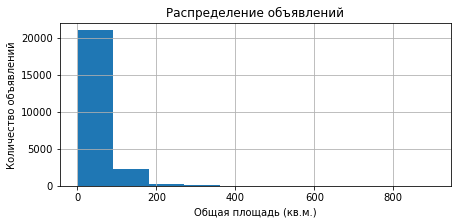

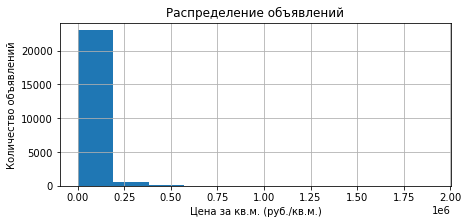

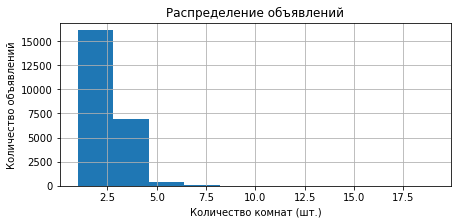

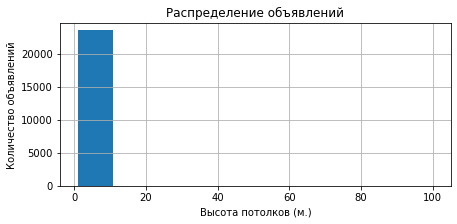

In [60]:
parametrs = {'total_area':'Общая площадь (кв.м.)', 'square_meter_price':'Цена за кв.м. (руб./кв.м.)', 'rooms':'Количество комнат (шт.)', 'ceiling_height':'Высота потолков (м.)'}
for parametr, parametr_synonym in parametrs.items():
    df.hist(column = parametr, figsize=(7, 3))
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.title('Распределение объявлений')
    plt.show()

Построены гистограммы со значениями по умолчанию. Из гистограм видно, что у распределений очень длинный хвост. Это значит, что есть выбросы. Теперь нужно почистить выбросы.  
Выбросами является все значения, которые больше 95/99 персентиля (это примерно эквивалент верхнего уса диаграммы размаха) всех значений и меньше 5 персентиля (это примерно эквивалент нижнего уса диаграммы размаха). Определить границы значений можно методом quantile()

Построим диаграммы ящик с усами и проанализируем выбросы. Диаграмму с усами можно построить двумя способами: с использованием библиотеки matplotlib.pyplot или seaborn. Рассмотрим оба варианта

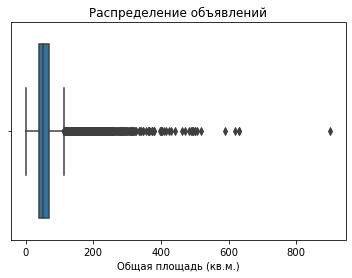

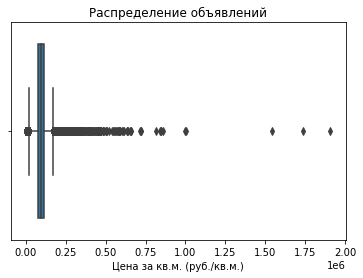

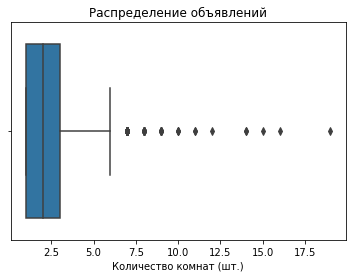

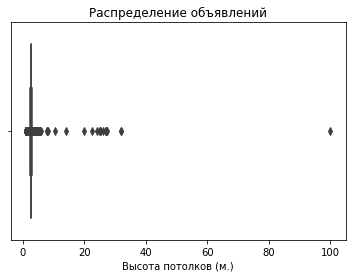

In [61]:
import seaborn as sns
for parametr, parametr_synonym in parametrs.items():
    sns.boxplot(df[parametr]).set(title='Распределение объявлений', xlabel=parametr_synonym)
    plt.show()

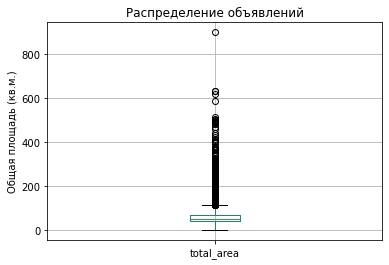

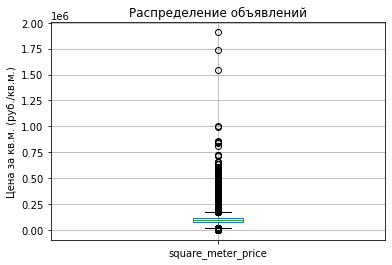

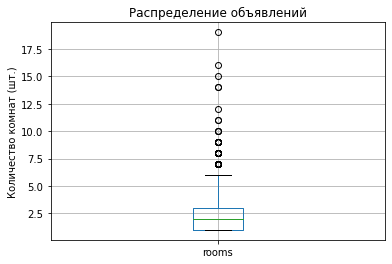

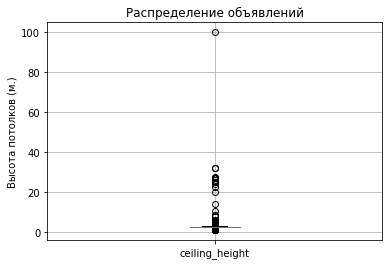

In [62]:
for parametr, parametr_synonym in parametrs.items():
    df.boxplot(parametr).set(title='Распределение объявлений', ylabel=parametr_synonym)
    plt.show()

Нагляднее видно на диаграммах, построенных с использованием библиотеки seaborn. Большое число значений у параметров Общая площадь и Цена за кв.м. находятся за пределом верхнего уса, это говорит о большом количестве выбросов. Для значений параметра Количество комнат выбросов немного, они начинаются с отметки 6. Если посмотреть на диаграмму параметра Высота пололков, то можо заметить, что выбросов также немного, но из-за разброса значений (та, единственная квартира с высотой потолков 100 м.) уменьшается масштаб самой диаграммы, из-за чего она стала практически нечитабельной (неинформативной). Вывод можно сделать следующий: абсолютно у всех выбранных параметров есть значения, недостающие до нижнего уса и превышающие верхний ус (выбросы) и их необходимо обработать.  

Выбросами является все значения, которые больше 95/99 персентиля (это примерно эквивалент верхнего уса диаграммы размаха) всех значений и меньше 5 персентиля (это примерно эквивалент нижнего уса диаграммы размаха). Определить границы значений можно методом quantile()

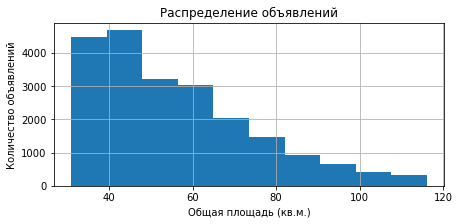

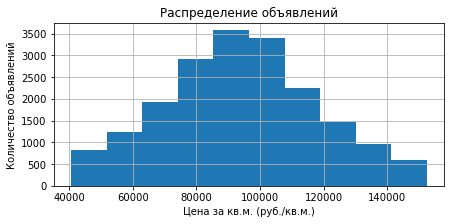

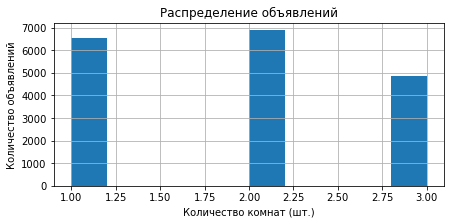

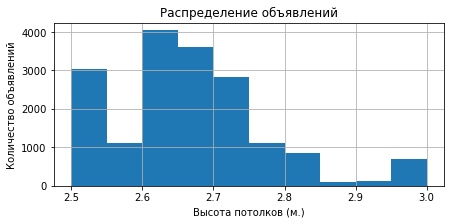

In [63]:
for parametr, parametr_synonym in parametrs.items():
    df = df[(df[parametr] <= df[parametr].quantile(0.95)) & (df[parametr] >= df[parametr].quantile(0.05))]
    df.hist(column = parametr, figsize=(7, 3))
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.title('Распределение объявлений')
    plt.show()

Гистограммы стали более читабельны и по ним уже можно сделать один небольшой вывод: чем больше значение любой характеристики, тем меньше предложений на рынке.  
Обработав данные от выбросов мы оставили только те, которые будут полезны в анализе. 

### 4.2. Изучение времени продажи квартиры<a id="4.2"></a> 

In [64]:
df['days_exposition'].describe()

count    15534.000000
mean       171.005214
std        209.219937
min          1.000000
25%         43.000000
50%         90.000000
75%        216.000000
max       1580.000000
Name: days_exposition, dtype: float64

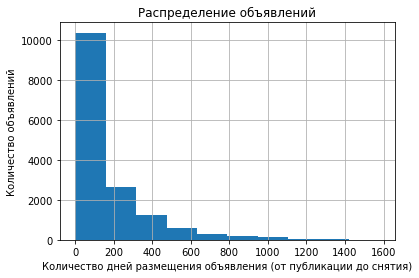

In [65]:
df.hist(column = 'days_exposition')
plt.xlabel('Количество дней размещения объявления (от публикации до снятия)'), plt.ylabel('Количество объявлений')
plt.title('Распределение объявлений')
plt.show()

Наблюдается длинный хвост, а это сигнализирует о наличии выбросов, воспользуемся методом boxplot(), его "усы" покажут нам пределы, за которыми находятся выбросы (ненормальные значения).

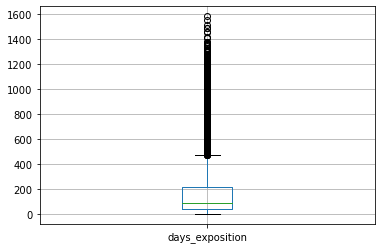

In [66]:
df.boxplot(column = 'days_exposition')
plt.show()

Первый ус равен 0, а вот второй примерно 500. Чтобы определить точное значение найдем  5 и 95 (эквивалент верхнего уса диаграммы размаха) персентиль значений

Обработаем данные и уберем выбросы

In [67]:
df = df[(df['days_exposition'] >= df['days_exposition'].quantile(0.05)) & (df['days_exposition'] <= df['days_exposition'].quantile(0.95))]

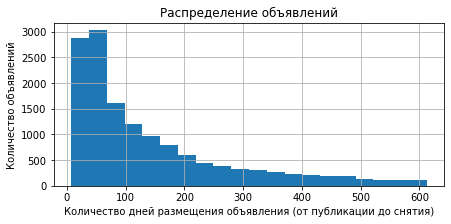

In [68]:
df.hist(column = 'days_exposition', bins = 20, figsize = (7,3))
plt.xlabel('Количество дней размещения объявления (от публикации до снятия)'), plt.ylabel('Количество объявлений')
plt.title('Распределение объявлений')
plt.show()

Вновь посмотрим на описание данных

In [69]:
df['days_exposition'].describe()

count    14086.000000
mean       141.421695
std        135.808111
min          8.000000
25%         45.000000
50%         90.000000
75%        194.000000
max        612.000000
Name: days_exposition, dtype: float64

Среднее количество дней, за которое объявление снимается с публикации = 140 дней (примерно 4,5 месяца), а медиана таких значений = 89 дней (примерно 3 месяца).  
Такое медианное значение может быть из-за результатов работы алгоритма автоматического закрытия объявлений (например, если установлено значение в 90 дней или 3 месяца).  
У большинства продажа обычно занимаеи не более 60 дней, но тут лучше обратиться к эксплуатационному персоналу для уточнения работы алгоритмов автоматического закрытия, т.к. это напрямую влияет на результаты анализа.  
За очень быстрые и очень долгие продажи принимаем крайние значения по квартилям диаграммы рассеяния, т.е.:  
   * Очень быстрые продажи проходят примерно за 10 дней 
   * Очень долгие продажи проходят примерно за 600 дней

### 4.3. Обработка редких и выбивающихся значений<a id="4.3"></a> 

В разделах 4.1 и 4.2 мы убирали выбросы в рамках выполнения задачи по изучению самих данных, но в оставшихся столбцах скорее всего также имеются выбросы.  
Проверим эту гипотезу и при необходимости обработаем выбросы аналогичным образом - оставляя данные, находящиеся в диапазон (0.05 - 0.95) перцентилей (что примерно соответствует нижнему и верхнему усам диаграммы размаха).  
Автоматизируем процесс используя цикл, в переменную `list_col` запишем нужные для анализа столбцы

In [70]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

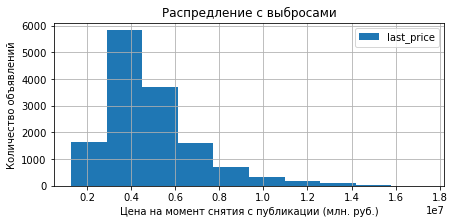

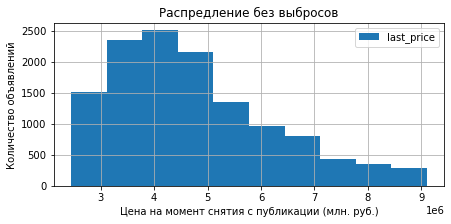

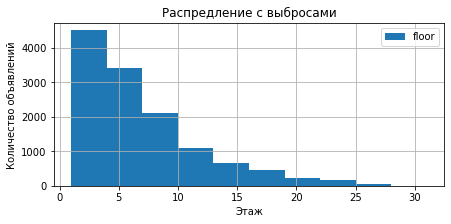

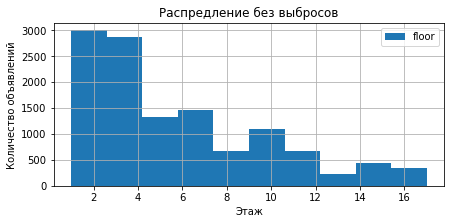

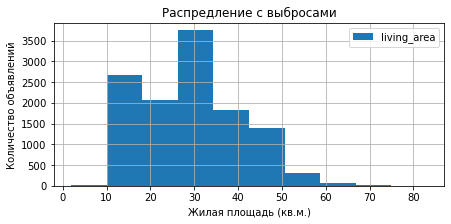

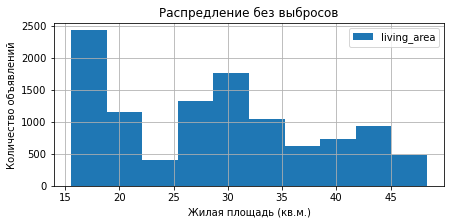

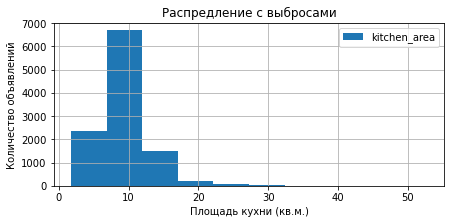

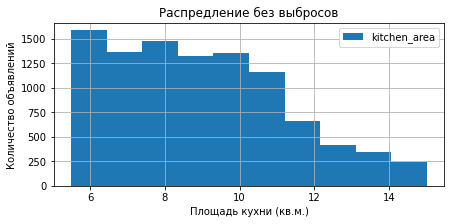

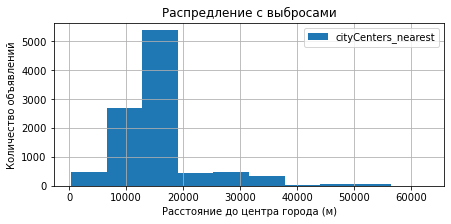

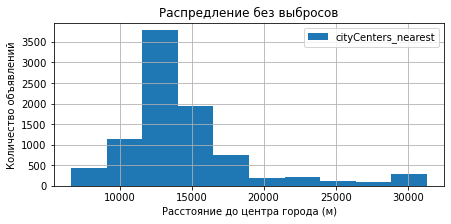

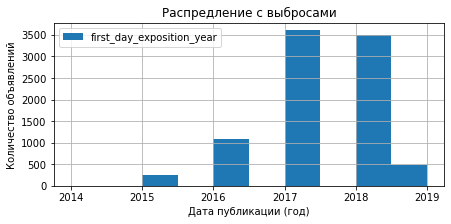

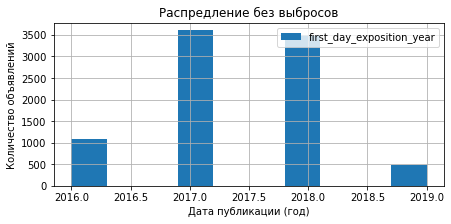

In [71]:
parametrs = {'last_price': 'Цена на момент снятия с публикации (млн. руб.)', 'floor':'Этаж', 'living_area':'Жилая площадь (кв.м.)', 'kitchen_area':'Площадь кухни (кв.м.)', 'cityCenters_nearest':'Расстояние до центра города (м)', 'first_day_exposition_year':'Дата публикации (год)'}
for parametr, parametr_synonym in parametrs.items():
    df.plot(kind='hist', y=parametr, figsize=(7, 3), grid=True, legend=True, title='Распредление с выбросами')
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.show()
    
    df = df[(df[parametr] <= df[parametr].quantile(0.95)) & (df[parametr] >= df[parametr].quantile(0.05))]
    df.plot(kind='hist', y=parametr, figsize=(7, 3), grid=True, legend=True, title='Распредление без выбросов')
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.show()

Обработка редких и выбивающихся значений также является одним из главных этапов предобработки, потому как будет неправильным судить о данных, если их количество слишком мало. Сравнивая гистограммы с выбросами и без можно заметить, что гистограммы без выбросов более информативнее по причине увеличение масштаба значений и более гладких переходов значений.

### 4.4. Изучение факторов, влияющих на стоимость квартиры<a id="4.4"></a>

#### 4.4.1. Зависимость цены от площади, числа комнат, удалённости от центра  

Для анализа зависимости цены от разных параметров воспользуемся построением графиков, и, если построив графики с параметров метода plot(): kind='scatter' мы получим большие облака данных, где отследить зависимость будет не так то просто.  
Построим графики, деленные на шестиугольные области и закрасим цветом данные области. Чем цвет темнее, тем количество точек при таких значениях больше.  
В отдельной переменной выпишем необходимые параметры, которые нужно проанализировать (наименования в заголовке)  
Также для каждого графика найдем коэффициент корреляции

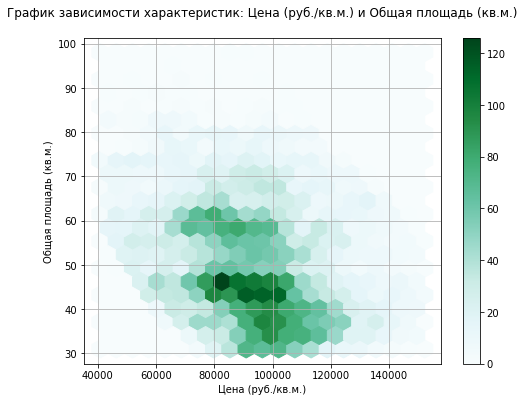

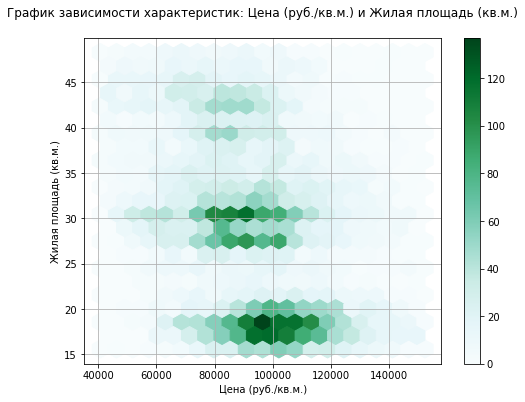

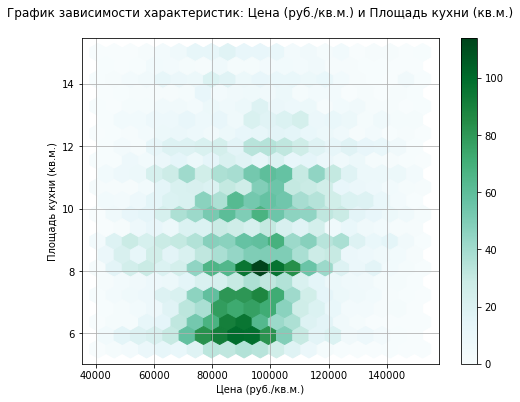

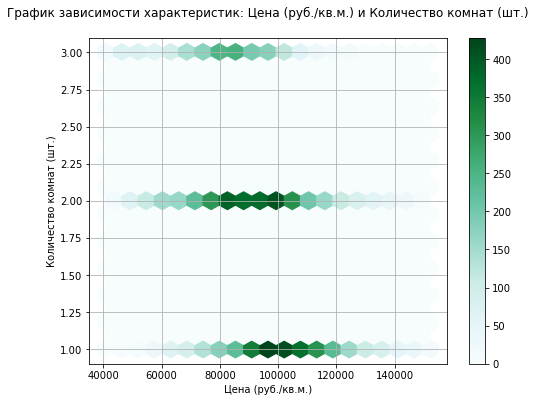

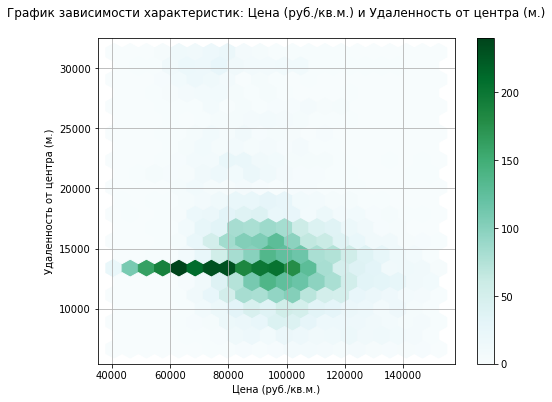

In [72]:
parametrs = {'total_area':'Общая площадь (кв.м.)', 'living_area':'Жилая площадь (кв.м.)', 'kitchen_area':'Площадь кухни (кв.м.)', 'rooms':'Количество комнат (шт.)', 'cityCenters_nearest':'Удаленность от центра (м.)'} 
for parametr, parametr_synonym in parametrs.items():
    df.plot(kind='hexbin', x = 'square_meter_price', y = parametr, gridsize=20, figsize=(8, 6), sharex=False, grid=True, title='График зависимости характеристик: Цена (руб./кв.м.) и ' + parametr_synonym + '\n') 
    plt.ylabel(parametr_synonym), plt.xlabel('Цена (руб./кв.м.)')
    plt.show()

Определим коэффициент корреляции для каждого графика. Для этого переведем parametrs из типа данных list в dataframe и добавим параметр `square_meter_price`

In [73]:
parametrs = df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'cityCenters_nearest', 'square_meter_price']] 

In [74]:
parametrs.corr()

,total_area,living_area,kitchen_area,rooms,cityCenters_nearest,square_meter_price
total_area,1.000000,0.891004,0.312285,0.808995,0.040626,-0.289637
living_area,0.891004,1.000000,-0.005150,0.913538,0.012847,-0.334974
kitchen_area,0.312285,-0.005150,1.000000,-0.117946,0.055569,0.103407
rooms,0.808995,0.913538,-0.117946,1.000000,0.004357,-0.360601
cityCenters_nearest,0.040626,0.012847,0.055569,0.004357,1.000000,-0.192867
square_meter_price,-0.289637,-0.334974,0.103407,-0.360601,-0.192867,1.000000


### Вывод:
**Зависимость цены от площади**  
Линейной зависимости у всех трех параметров (Общая площадь, жилая и кухня) нет, о чем может сказать нам коэффициент корреляции Пирсона - по модулю его значение не превышает и 0.34 пункта.  
Если посмотреть на графики, то заметим лишь несколько частотных зон. Для примера рассмотрим график зависимости от Общей площади: наиболее частые предложения квартир являются с общей площадью от 40 до 50 метров и стоимостью от 80 до 100 тыс. руб за 1 кв. м.  
При уменьшении/увеличении площади - уменьшается частота значений, при уменьшении/увеличении квадратуры аналогично - частота значений уменьшается.  
  
**Зависимость цены от числа комнат**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.36. Но на графике можно увидеть в диапазоне от 70 до 110 тыс. руб за кв. м. небольшую зависимость: при увеличении цены за 1 кв. м. уменьшается количество комнат в квартире.  
  
**Зависимость цены от удаленности от центра**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.19. График также не показывает зависимости, а только отражает, какие квартиры (с какими параметрами) чаще всего присутствуют на рынке недвижимости: это находящиеся около 15 км. от центра, у которых цена за 1 кв. м. варьируется в диапазоне от 60 до 85 тыс. руб. за 1 кв. м.  
  
Результаты зависимостей выше можно считать достаточно логичными, потому как квартиры с "маленькими" характеристиками не сильно распространены (ориентированы на молодых и одиноких людей), а квартиры с "большими" характеристиками распространены еще меньше (такие квартиры ориентированы на людей с высокой доходностью). 

#### 4.4.2. Зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом

В данном случае уже необходимо воспользоваться группировкой по выделенным категориям для этажей  

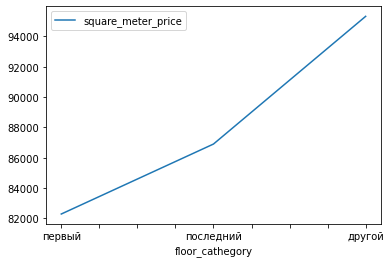

In [75]:
report = df.groupby('floor_cathegory').agg({'square_meter_price' : 'median'});
report.sort_values(by='square_meter_price').plot();

Вывод:  на графике явно видно, что цена на первых и последних этажах ниже, чем на средних этажах. Таким образом мы видим нелинейную зависимость (линейная была бы если бы, например, цена росла или падала стабильно с увеличением этажа).

#### 4.4.3. Зависимость цены от даты размещения: дня недели, месяца и года

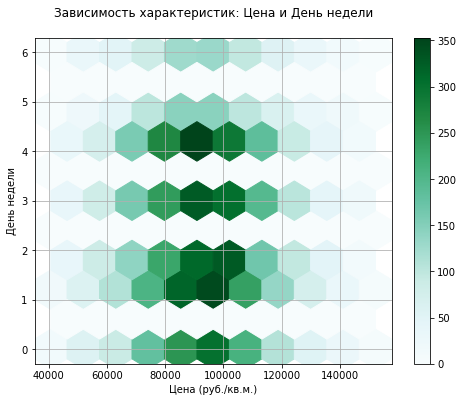

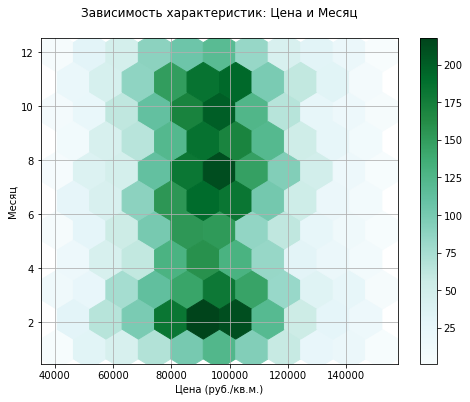

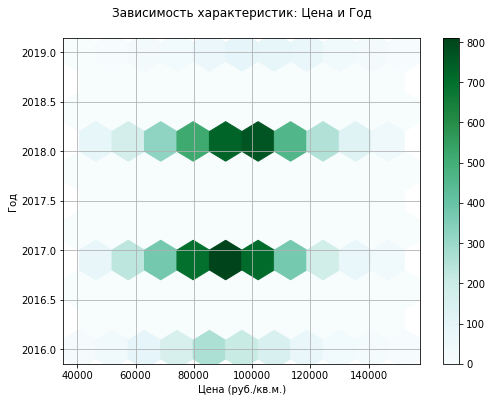

In [76]:
parametrs = {'first_day_exposition_weekday':'День недели', 'first_day_exposition_month':'Месяц', 'first_day_exposition_year':'Год'} 
for parametr, parametr_synonym in parametrs.items():
    df.plot(kind='hexbin', x = 'square_meter_price', y = parametr, gridsize=10, figsize=(8, 6), sharex=False, grid=True, title='Зависимость характеристик: Цена и ' + parametr_synonym + '\n') 
    plt.ylabel(parametr_synonym), plt.xlabel('Цена (руб./кв.м.)')
    plt.show()

In [77]:
parametrs = df[['first_day_exposition_weekday', 'first_day_exposition_month', 'first_day_exposition_year', 'square_meter_price']] 

In [78]:
parametrs.corr()

,first_day_exposition_weekday,first_day_exposition_month,first_day_exposition_year,square_meter_price
first_day_exposition_weekday,1.000000,0.003399,-0.007648,0.004382
first_day_exposition_month,0.003399,1.000000,-0.186017,0.009624
first_day_exposition_year,-0.007648,-0.186017,1.000000,0.126322
square_meter_price,0.004382,0.009624,0.126322,1.000000


### Выводы:  
**Зависимость цены от дня недели**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.004. По графику заметно, что чаще всего размещение объявление проводится в будние дни. Думаю это можно объяснить графиком работы компаний, предоставляющих риэлторские услуги (с ПН по ПТ). Цены на квартиры не зависят от дня недели размещения объявления.  
  
**Зависимость цены от месяца**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.009. По графику можно увидеть, что размещаются объявления с одинаковой частотой в течение года, небольшие "просадки" присутствуют в весенний период и в новогодние праздники (декабь-январь). Цены на квартиры не зависят от месяца размещения объявления.
  
**Зависимость цены от года**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.12. По сравнению с предыдущими графиками, зависимость с годами все же наблюдается, но едва-едва. К сожаленью, в "чистые" данные попало слишком мало данных за более старые года. Если смотреть на срез 2017-2018 годов, то цена немного увеличилась (если учесть инфляцию, то можно сказать, что зависимости нет). За 2019 год данных практически нет, это связано с тем, что выгрузку данных делали именно в 2019 и было достаточно много незакрытых объявлений. 

### 4.5. Исследование 10 населённых пунктов с наибольшим числом объявлений<a id="4.5"></a>

#### 4.5.1. Найдем топ 10 населённых пунктов с наибольшим числом объявлений

In [79]:
report = (
    df.groupby('locality_name')
    .agg({'first_day_exposition': 'count'})
    .sort_values('first_day_exposition', ascending=False)
    .head(10)
)

In [80]:
report

,first_day_exposition
locality_name,
Санкт-Петербург,6270
поселок Мурино,238
поселок Шушары,234
Всеволожск,192
деревня Кудрово,140
Гатчина,137
поселок Парголово,117
Пушкин,116
Выборг,80


In [81]:
top_10_locations = report.index.tolist()

In [82]:
top_10_locations

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'деревня Кудрово',
 'Гатчина',
 'поселок Парголово',
 'Пушкин',
 'Выборг',
 'деревня Новое Девяткино']

#### 4.5.2. Анализ квартир из топ 10 населенных пунктов

Посчитаем среднюю цену квадратного метра в этих населённых пунктах и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [83]:
report = df.query('locality_name in @top_10_locations')

In [84]:
report.groupby('locality_name').agg({'square_meter_price':'mean'}).sort_values('square_meter_price')

,square_meter_price
locality_name,
Выборг,58312.873314
Всеволожск,67439.930727
Гатчина,70075.135375
деревня Новое Девяткино,76281.863501
поселок Шушары,76801.508089
поселок Мурино,82995.718763
поселок Парголово,86064.136180
деревня Кудрово,92239.756708
Санкт-Петербург,100133.558606


### Вывод:
Среди 10 населынных пунктов с наибольшим числом объявлений **Выборг** является городом с наименьшей ценой равной 58 тыс.р. за 1 кв. м., а **Пушкин** - с наибольшей ценой равной 101 тыс.р. за 1 кв.м.  


### 4.6. Определение центральной зоны<a id="4.6"></a>
Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге и выясним, какая область входит в центр.  
Создадим столбец с расстоянием до центра в километрах, округлим до целых значений, после этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [85]:
spb_location = df.query('locality_name == "Санкт-Петербург"')

Создадим столбец `cityCenters_nearest_km` с расстоянием до центра в километрах и округлим до целых значений (а также переведем в тип данных int).

In [86]:
spb_location['cityCenters_nearest_km'] = (spb_location['cityCenters_nearest'] // 1000).astype('int64')

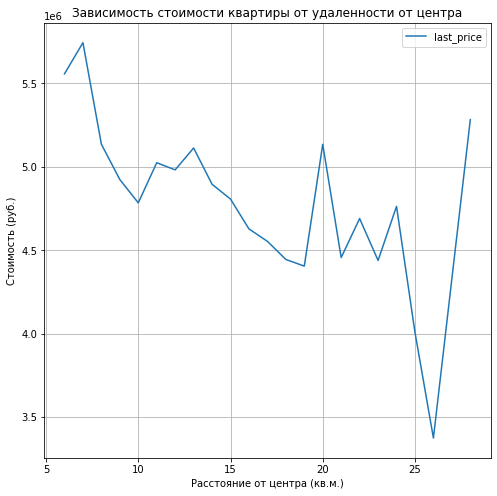

In [87]:
(spb_location
     .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
     .plot(grid=True, figsize=(8, 8))
);
plt.ylabel('Стоимость (руб.)'), plt.xlabel('Расстояние от центра (кв.м.)')
plt.title('Зависимость стоимости квартиры от удаленности от центра')
plt.show()

Границей центра является отметка равная 10 км. Граница выбрана по графику зависимости стоимости от удаленности - при отметки в 10 км. график резко меняет направление на увеличение стоимости при увеличении расстояния от центра. Таким образом можно сказать, что закончилась центральная зона города и начались зоны других районов

### 4.7. Анализ квартир в Санкт-Петербурге<a id="4.7"></a>

Информацию будем анализировать для квартир в центре СПб и для квартир во всем СПб.  
Выделим сегмент квартир в центре

In [88]:
spb_flats_center = spb_location.query('cityCenters_nearest_km < 10')

In [89]:
spb_flats_center.head()

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,days_exposition,cityCenters_nearest,square_meter_price,first_day_exposition_year,first_day_exposition_month,first_day_exposition_weekday,floor_cathegory,ratio_living_to_total,ratio_kitchen_to_total,cityCenters_nearest_km
21,3200000.0,31.6,2018-03-14,1,2.65,5,16.9,2,False,False,...,310.0,9722.0,101265.822785,2018,3,2,другой,0.534810,0.180380,9
56,4350000.0,41.0,2016-03-28,1,2.80,7,18.1,4,False,False,...,152.0,9626.0,106097.560976,2016,3,0,другой,0.441463,0.270732,9
85,5200000.0,46.3,2018-11-26,2,3.00,5,27.8,5,False,False,...,65.0,9319.0,112311.015119,2018,11,0,последний,0.600432,0.172786,9
103,4800000.0,35.0,2018-10-04,1,2.70,25,17.0,9,False,False,...,19.0,9719.0,137142.857143,2018,10,3,другой,0.485714,0.257143,9
115,3850000.0,42.0,2018-11-05,2,2.65,5,27.0,4,False,False,...,73.0,8535.0,91666.666667,2018,11,0,другой,0.642857,0.154762,8


#### 4.7.1 Проанализируем квартиры в Санкт-Петербурге и изучим следующие параметры: площадь, цена, число комнат, высота потолков.

Изучить значение параметров, влияющих на стоимость квартиры можно несколькими способами.  
Первый - это посмотреть на каждую гистограмму в отдельности

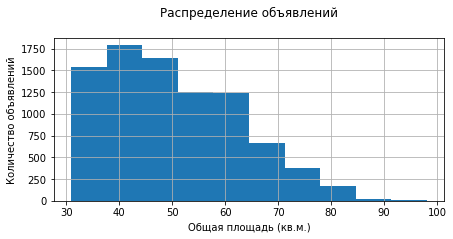

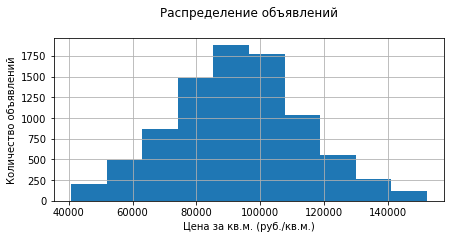

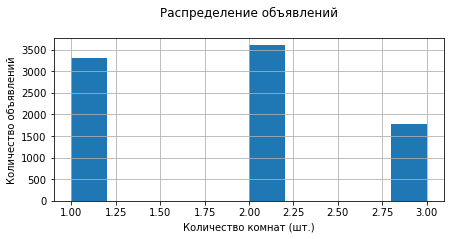

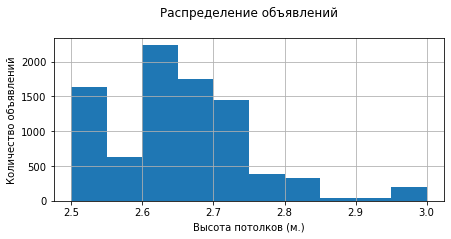

In [90]:
parametrs = {'total_area':'Общая площадь (кв.м.)', 'square_meter_price':'Цена за кв.м. (руб./кв.м.)', 'rooms':'Количество комнат (шт.)', 'ceiling_height':'Высота потолков (м.)'}
for parametr, parametr_synonym in parametrs.items():
    df.hist(column = parametr, figsize=(7, 3))
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.title('Распределение объявлений\n')
    plt.show()

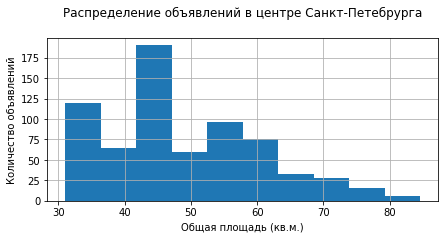

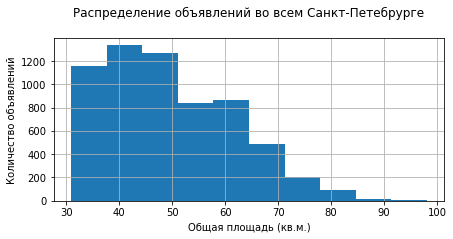

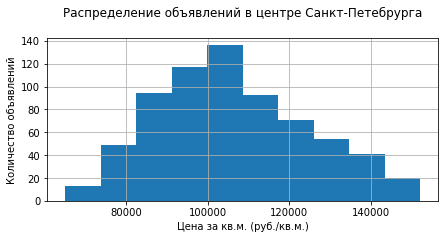

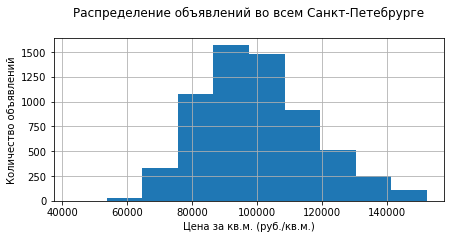

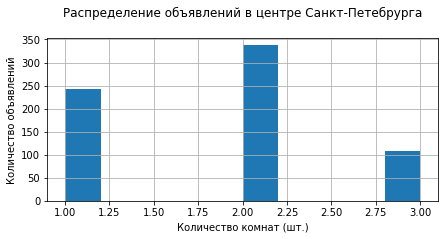

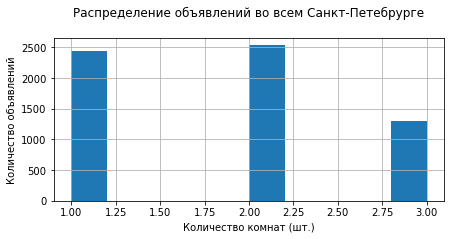

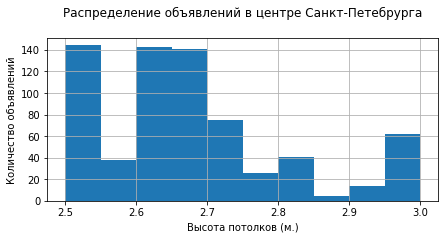

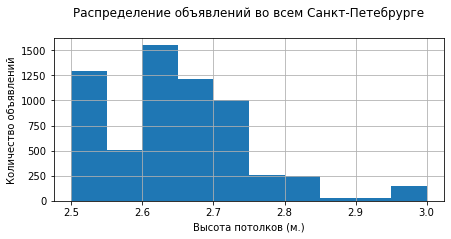

In [91]:
parametrs = {'total_area':'Общая площадь (кв.м.)', 'square_meter_price':'Цена за кв.м. (руб./кв.м.)', 'rooms':'Количество комнат (шт.)', 'ceiling_height':'Высота потолков (м.)'}
for parametr, parametr_synonym in parametrs.items():
    spb_flats_center.hist(column = parametr, figsize=(7, 3), bins=10, grid=True)
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.title('Распределение объявлений в центре Санкт-Петебрурга\n')
    plt.show()
    
    spb_location.hist(column = parametr, figsize=(7, 3), bins=10, grid=True)
    plt.xlabel(parametr_synonym), plt.ylabel('Количество объявлений')
    plt.title('Распределение объявлений во всем Санкт-Петебрурге\n')
    plt.show()

И второй - это построить попарную точечную диаграмму для столбцов датафрейма. Графики по диагонали покажут нам нужный результат.  
Используя второй способ визуально удобнее видеть и делать выводы. 

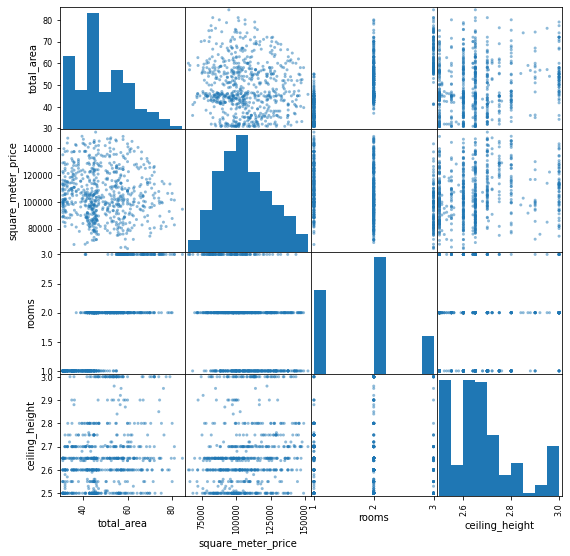

In [92]:
parametrs = spb_flats_center[['total_area', 'square_meter_price', 'rooms', 'ceiling_height']]
pd.plotting.scatter_matrix(parametrs, figsize=(9,9));

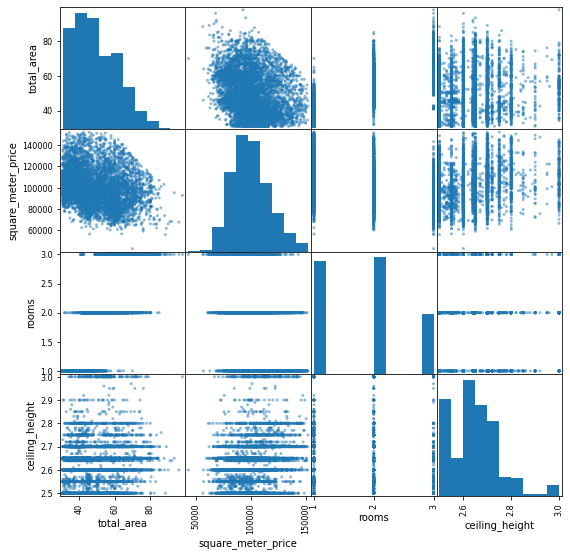

In [93]:
parametrs = spb_location[['total_area', 'square_meter_price', 'rooms', 'ceiling_height']]
pd.plotting.scatter_matrix(parametrs, figsize=(9,9));

### Вывод:  
Для параметров *цена* и *количество комнат* графики имеют нормальное распределение - сначала идет нарастание, после пика спад частоты значений.  
Для параметров *Общая площадь* и *высота потолков* графики имеют вид распределения Пуассона, они имеет высокое начало и уменьшающийся конец.  

**Сравнение квартир в центре Санкт-Петербурга и квартир во всем Санкт-Петербурге**  
Если посмотреть на квартиры по характеристике *площадь*, то можно увидеть, что во всем СПб бОльшее количество квартир с меньшей общей площадью. Такие значения можно объяснить несколькими причинами:  
   1. Раньше строили квартиры меьшей квадратурой. Центром обычно считается место, откуда начинал застраиваться город с самого его зарождения. Новые дома (новостройки) строят уже в зависимости от потребностей текущего поколения, а данные потребности требуют бОльшей квадратуры. 
   2. В центре города обычно есть все, что необходимо человеку для жизни и даже больше. Благодаря шаговой доступности квартиры в центре города дороже, и, соответственно, застройщики хотят за небольшое количество квадратных метров получить больше денег. Поэтому. выгоднее строить дома с небольшой общей площадью.  
  
Описанные выше причины малой общей площади квартиры также объясняют почему в центре преобладает квартир с 1 и 2 комнатами, в то время как 3-х комнатных очень мало. Во всем СПб количество 1 и 2 комнатных примерно равное, а 3-комнатных вдвое меньше. 

#### 4.7.2. Изучение факторов, влияющих на стоимость квартиры в центре Санкт-Петербурга

Изучим зависимость цены от числа комнат, этажа, удалённости от центра, даты размещения объявления. Воспользуемся ранее уже использованными графиками, деленных на шестиугольные области

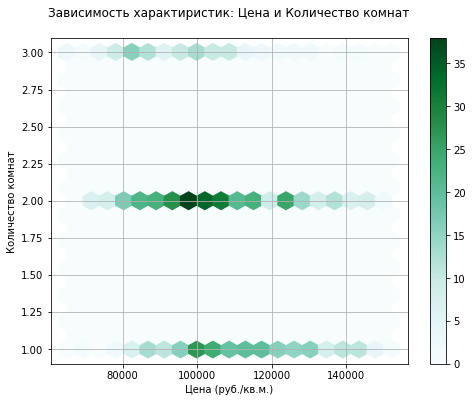

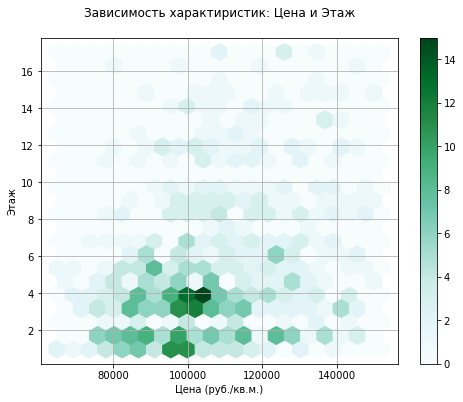

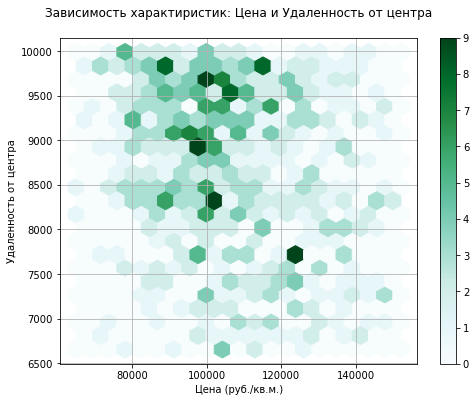

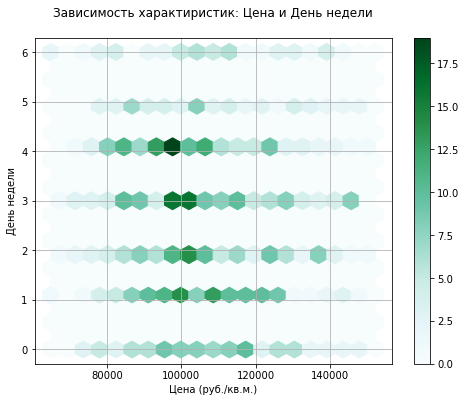

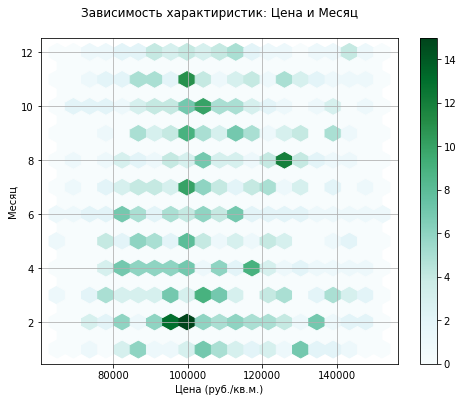

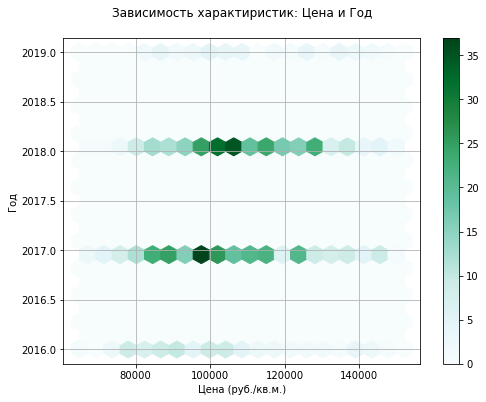

In [94]:
parametrs = {'rooms':'Количество комнат', 'floor': 'Этаж', 'cityCenters_nearest':'Удаленность от центра', 'first_day_exposition_weekday':'День недели', 'first_day_exposition_month':'Месяц', 'first_day_exposition_year':'Год'} 
for parametr, parametr_synonym in parametrs.items():
    spb_flats_center.plot(kind='hexbin', x = 'square_meter_price', y = parametr, gridsize=20, figsize=(8, 6), sharex=False, grid=True, title='Зависимость характиристик: Цена и ' + parametr_synonym + '\n') 
    plt.ylabel(parametr_synonym), plt.xlabel('Цена (руб./кв.м.)')
    plt.show()

In [95]:
parametrs = spb_flats_center[['rooms', 'floor', 'cityCenters_nearest', 'first_day_exposition_weekday', 'first_day_exposition_month', 'first_day_exposition_year', 'square_meter_price']]

In [96]:
parametrs.corr()

,rooms,floor,cityCenters_nearest,first_day_exposition_weekday,first_day_exposition_month,first_day_exposition_year,square_meter_price
rooms,1.000000,-0.146031,-0.109350,0.037732,-0.001114,-0.010769,-0.302346
floor,-0.146031,1.000000,0.028046,0.004317,0.026332,0.017650,0.266914
cityCenters_nearest,-0.109350,0.028046,1.000000,-0.006314,-0.099231,-0.030476,-0.206531
first_day_exposition_weekday,0.037732,0.004317,-0.006314,1.000000,-0.020658,-0.014907,-0.022690
first_day_exposition_month,-0.001114,0.026332,-0.099231,-0.020658,1.000000,-0.214574,0.012177
first_day_exposition_year,-0.010769,0.017650,-0.030476,-0.014907,-0.214574,1.000000,0.176491
square_meter_price,-0.302346,0.266914,-0.206531,-0.022690,0.012177,0.176491,1.000000


### Вывод:  
**Зависимость цены от количества комнат**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.3. Небольшая зависимость все же есть, если смотреть количество комнат по отдельности, то заметно, что частота значений при увеличении цены сначала немного растет, а затем уменьшается. Большинство предложений для квартир в центре СПб - 2-х комнатные квартиры при цене за 1 кв. м. от 90 до 110 тыс. р.  
  
**Зависимость цены от этажа**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.26. Небольшая зависимость все же есть, при увеличении цены за 1 кв.м. можно заметить, график сначала увеличивается по частоте, а после 100 тыс. р. стремительно уменьшается по частоте. Как и на предыдущем графике, основные предложения по квартирам в центре СПб имеют параметры: цена за 1 кв. м. варьруется от 90 до 110 тыс. р., расположенные до 4 этажа  
  
**Зависимость цены от удаленности от центра**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.2. На графике можно заметить, что до 8 км. центральной части СПб мало предложений по цене до 160 тыс.р. за кв.м., можно предположить, что предложения в данном сегменте также есть, но их слишком мало и мы их убрали при обработке выбросов. Основные предложения по квартирам находятся ближе к краю центральной части СПб и, конечно, в ценовом диапазоне от 90 до 110 тыс. р. за кв.м.

**Зависимость цены от дня недели**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.022. По графику заметно, что чаще всего размещение объявление проводится в будние дни. Это опять таки можно объяснить графиком работы компаний, предоставляющих риэлторские услуги (с ПН по ПТ).  
  
**Зависимость цены от месяца**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.012. По графику можно увидеть, что размещаются объявления с одинаковой частотой в течение года, небольшие "просадки" присутствуют в новогодние праздники (декабь-январь), а также заметно в феврале наибольшую частоту среди всех значений.  
  
**Зависимость цены от года**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.17. По сравнению с предыдущими графиками, зависимость с годами все же наблюдается, но едва-едва. К сожаленью, в "чистые" данные попало слишком мало данных за более старые года. Если смотреть на срез 2017-2018 годов, то цена немного увеличилась (если учесть инфляцию, то можно сказать, что зависимости нет). За 2019 год данных практически нет, это связано с тем, что выгрузку данных делали именно в 2019 и было достаточно много незакрытых объявлений. 

#### 4.7.3. Изучение факторов, влияющих на стоимость квартиры во всем Санкт-Петербурге

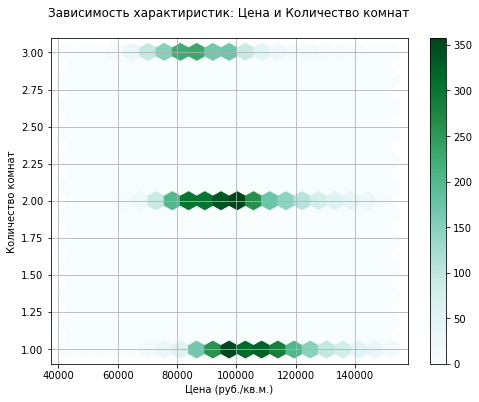

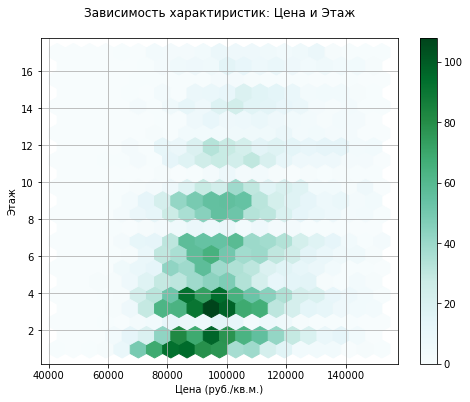

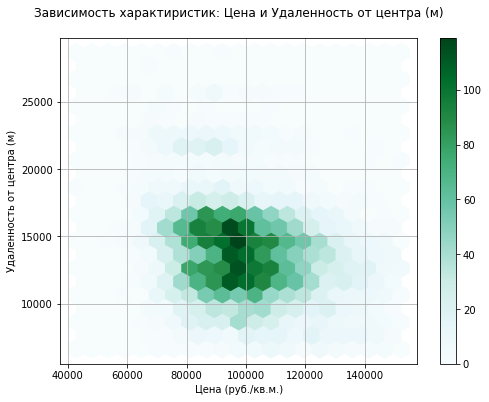

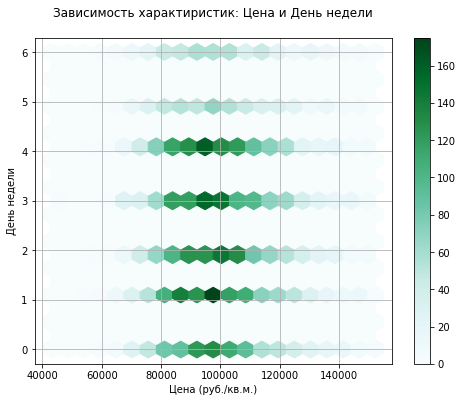

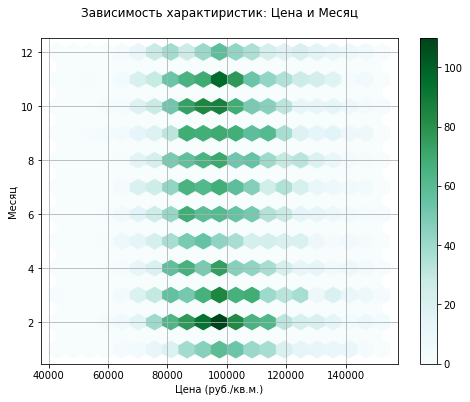

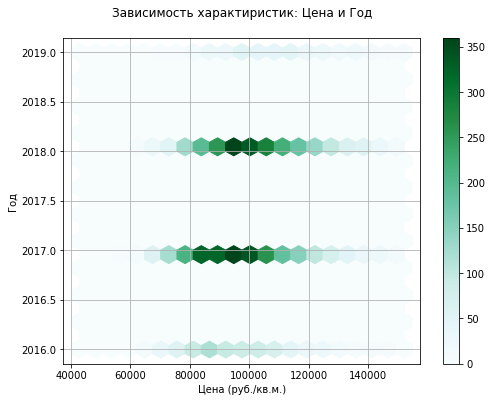

In [97]:
parametrs = {'rooms':'Количество комнат', 'floor': 'Этаж', 'cityCenters_nearest':'Удаленность от центра (м)', 'first_day_exposition_weekday':'День недели', 'first_day_exposition_month':'Месяц', 'first_day_exposition_year':'Год'} 
for parametr, parametr_synonym in parametrs.items():
    spb_location.plot(kind='hexbin', x = 'square_meter_price', y = parametr, gridsize=20, figsize=(8, 6), sharex=False, grid=True, title='Зависимость характиристик: Цена и ' + parametr_synonym + '\n') 
    plt.ylabel(parametr_synonym), plt.xlabel('Цена (руб./кв.м.)')
    plt.show()

In [98]:
parametrs = spb_location[['rooms', 'floor', 
                          'cityCenters_nearest', 'first_day_exposition_weekday', 
                          'first_day_exposition_month', 'first_day_exposition_year', 'square_meter_price']]

In [99]:
parametrs.corr()

,rooms,floor,cityCenters_nearest,first_day_exposition_weekday,first_day_exposition_month,first_day_exposition_year,square_meter_price
rooms,1.000000,-0.192285,-0.019753,-0.005897,0.008392,-0.025067,-0.417473
floor,-0.192285,1.000000,0.059805,0.014189,0.005881,0.015263,0.242060
cityCenters_nearest,-0.019753,0.059805,1.000000,-0.021605,0.020388,0.001965,-0.234854
first_day_exposition_weekday,-0.005897,0.014189,-0.021605,1.000000,-0.020269,0.002231,0.001252
first_day_exposition_month,0.008392,0.005881,0.020388,-0.020269,1.000000,-0.190816,-0.006315
first_day_exposition_year,-0.025067,0.015263,0.001965,0.002231,-0.190816,1.000000,0.185977
square_meter_price,-0.417473,0.242060,-0.234854,0.001252,-0.006315,0.185977,1.000000


### Вывод:  
**Зависимость цены от количества комнат**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.41. На графике можно увидеть небольшую зависимость: при увеличении цены уменьшается количество комнат. Большинство предложений для квартир во всем СПб:
   * 1-комнатные квартиры при цене за кв. м. от 90 до 120 тыс. р.
   * 2-комнатные квартиры при цене за кв. м. от 70 до 110 тыс. р. 
  
**Зависимость цены от этажа**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.24. Небольшая зависимость все же есть, при увеличении цены за 1 кв.м. можно заметить, график сначала увеличивается по частоте, а после 100 тыс. р. стремительно уменьшается по частоте. Основные предложения по квартирам во всем СПб имеют параметры: цена за кв. м. варьруется от 75 до 110 тыс. р., расположенные до 4 этажа  
  
**Зависимость цены от удаленности от центра**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.23. На графике можно заметить, что большинство квартир находятся за пределами центральной части города в диапазоне от 11 до 17 км и цене за кв. м. от 80 до 120 тыс.р.. 
  
**Зависимость цены от дня недели**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.001. По графику заметно, что чаще всего размещение объявление проводится в будние дни. Это опять таки можно объяснить графиком работы компаний, предоставляющих риэлторские услуги (с ПН по ПТ).  
  
**Зависимость цены от месяца**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.006. По графику можно увидеть, что размещаются объявления с одинаковой частотой в течение года, небольшие "просадки" присутствуют в новогодние праздники (декабь-январь), а также заметно в феврале наибольшую частоту среди всех значений.  
  
**Зависимость цены от года**  
Линейной зависимости нет, коэффициент корреляции Пирсона равен 0.18. По графику можно увидеть, что по сравнению с 2017, в 2018 году цена за кв. м. в диапазоне от 100 тыс. р. практически не изменилась, т.е. количество предложений не изменилось. А вот с меньшей ценой уже куда-меньше предложений. За 2019 год данных практически нет, это связано с тем, что выгрузку данных делали именно в 2019 и было достаточно много незакрытых объявлений. 

### Общий вывод по параметрам квартир
Самые "ходовые" квартиры в центре (до 10 км) Санкт-Петербурга имеют следующие характеристики:  
   * цена: от 90 до 110 тыс. р. за 1 кв. метр
   * количество комнат: 2
   * этаж: до 4 включительно
   * расположение: ближе к окраине центральной части (от 8,5 км)
  
Самые "ходовые" квартиры во всем Санкт-Петербурга имеют следующие характеристики:  
   * цена: от 70 до 120 тыс. р. за 1 кв. метр
   * количество комнат: 1 и 2
   * этаж: до 4 включительно
   * расположение: расстояние от центра от 11 до 17 км. 

## 5. Общий вывод<a id="5"></a>

#### Какие факторы больше всего влияют на стоимость квартиры?  
На стоимость квартиры влияют следующие факторы:  
   * **площадь**: линейной зависимости нет, однако выделяется диапазон с наибольшим количеством объявлений - с общей площадью от 40 до 50 метров и стоимостью от 80 до 100 тыс. руб за кв. м.  
   * **количество комнат**: наиболеьшее количество объявлений содержат 1 или 2-комнатные квартиры, реже 3-комнатные. При увеличении цены за 1 кв. м. уменьшается количество комнат в квартирею В зависимости от района цена за 1 и 2-комнатные меняется:  
       _**В центре Санкт-Петербурга:**_  
       1-комнатные квартиры при цене за кв. м. от 90 до 120 тыс. р.  
       2-комнатные квартиры при цене за кв. м. от 70 до 110 тыс. р.  
       _**Во всем Санкт-Петербурге:**_  
       1-комнатные квартиры при цене за кв. м. от 90 до 120 тыс. р.  
       2-комнатные квартиры при цене за кв. м. от 90 до 110 тыс. р.  
       _**По области:**_  
       1-комнатные квартиры при цене за кв. м. от 90 до 120 тыс. р.  
       2-комнатные квартиры при цене за кв. м. от 70 до 110 тыс. р.  
   * **удаленность от центра**: наибольшее количество объявлений с удаленностью от центра от 8 до 17 км, аналогично как в случае с количеством комнат, диапазон цен меняется в зависимости от района:  
       _**В центре Санкт-Петербурга:**_  
       при удаленности в диапазоне от 8 до 10 км. цена за кв. м. от 90 до 110 тыс. р.  
       _**Во всем Санкт-Петербурге:**_  
       при удаленности в диапазоне от 11 до 17 км. цена за кв. м. от 80 до 120 тыс. р.  
       _**По области:**_  
       при удаленности в диапазоне от 13 до 15 км. цена за кв. м. от 50 до 110 тыс. р.  
   * **этаж**: наименьшая цена у квартир на 1 этаже, на втором месте квартиры с последний этажом и наибольшцена у квартир "между первым и последним".  
       Это логично, так как есть устоявшиеся стереотипы и жизненные практики: на первом этаже прохожие заглядывают в квартиру через окно с улицы, в подвале обязательно крысы и по вечерам на лавочке возле окна гарланят "Батарейку", на последнем этаже - протекает крыша.  
  
Цена не зависит от дня недели/месяца публикации объявления, в зависимости от года видится увеличение стоимости, но оно совсем небольшое и это больше связано с экономикой в стране, в один год на сумму 4 млн. руб ты можешь купить неплохую 2-комнатную, а на следующий год этих денег уже не хватит. 
  
**Топ 3 населенных пункта, в которых цена за 1 кв.м. является наибольшей**:  
   1. Пушкин, 101009 руб. за 1 кв.м.
   2. Санкт-Петербург, 100133 руб. за 1 кв.м.
   3. деревня Кудрово	92239 руб. за 1 кв.м.  
  
**Центр Санкт-Петербурга**  
В процессе анализа было определено, что центром Санкт-Петербурга является расстояние до 10 км. 

Таким образом, мы завершили наше исследование объявлений о продаже квартир. Мы получили представление как в целом о рынке, так и выделили отдельные параметры, которые влияют на цену квартиры в регионе. Стоит отметить, что из выборки была убрана вся элитная недвижимость, так как она смещала результаты. В результате очистки данных остались только "средние" результаты, типичные для региона квартиры. 